# Red neuronal convolucional para clasificación de galaxias según su morfología
El estudio y clasificación de galaxias es una tarea fundamental en la astronomía, ya que nos permite comprender la evolución y estructura del universo. Sin embargo, analizar manualmente la morfología de galaxias es una tarea compleja y laboriosa, especialmente en grandes conjuntos de datos astronómicos.

En este contexto, el uso de Redes Neuronales Convolucionales (CNN) surge como la solución más lógica. Estas redes están diseñadas para aprender automáticamente características visuales relevantes en las imágenes, lo que las hace ideales para extraer patrones de forma, tamaño y textura en las galaxias.

La importancia del presente trabajo radica en su capacidad para acelerar y automatizar la clasificación de galaxias, permitiendo analizar grandes cantidades de datos de manera eficiente y precisa.





### Importación de librerías

Procedemos a importar todas las librerías necesarias para el desarrollo del proyecto:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import random
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import shutil
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

2023-07-30 22:39:45.969642: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 22:39:45.990889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cabe destacar que hay que tener las imágenes de las galaxias de antemano para la realización del proyecto:

In [ ]:
# Directorio que contiene todas las imágenes de galaxias
ruta_al_directorio_de_imagenes = '/home/vpinto/teaching/train'  #

# Directorio base donde se crearán los subdirectorios para cada tipo de galaxia
directorio_base = '/home/vpinto/teaching/imagenes_ordenadas'  # Ajusta la ruta del directorio base donde se crearán los subdirectorios

# Obtener la lista de nombres de archivos de imágenes en el directorio
image_files = [file for file in os.listdir(ruta_al_directorio_de_imagenes) if os.path.isfile(os.path.join(ruta_al_directorio_de_imagenes, file))]

In [ ]:
print(image_files)

[]


In [ ]:
 # Crear subdirectorios para cada tipo de galaxia
for file in image_files:
    # Obtener el tipo de galaxia del nombre del archivo (asumiendo que el tipo está antes del primer punto '.')
    tipo_galaxia = file.split('.')[0]

    # Crear subdirectorio para el tipo de galaxia si no existe
    tipo_galaxia_dir = os.path.join(directorio_base, tipo_galaxia)
    os.makedirs(tipo_galaxia_dir, exist_ok=True)

    # Mover la imagen al subdirectorio correspondiente
    src_path = os.path.join(ruta_al_directorio_de_imagenes, file)
    if len(os.listdir(tipo_galaxia_dir)) < 0.8 * len(image_files):
        dst_path = os.path.join(tipo_galaxia_dir, file)
        shutil.move(src_path, dst_path)


In [ ]:
def plot_random_galaxy(path):
    image_files = os.listdir(path)

    if not image_files:
        print("El directorio no contiene imágenes.")
        return

    random_image = random.choice(image_files)

    random_image = random.choice(image_files)

    plt.figure(figsize=(6, 6))
    img = tf.io.read_file(os.path.join(path, random_image))
    img = tf.io.decode_image(img)
    plt.imshow(img)
    plt.title(f'Class: {random_image}\nShape: {img.shape}')
    plt.axis(False)

plot_random_galaxy("/home/vpinto/teaching/imagenes_ordenadas/edge")
plt.show()

El directorio no contiene imágenes.


A continuación se toma un directorio base que contiene subdirectorios para diferentes tipos de galaxias. Luego, para cada tipo de galaxia, se itera sobre las imágenes presentes en su subdirectorio. Cada imagen es redimensionada a un tamaño de 128x128 píxeles y se normalizan los valores de los píxeles en el rango [0, 1]. Posteriormente, se guardan las imágenes redimensionadas y normalizadas en el mismo directorio, reemplazando las imágenes originales. Este proceso se repite para cada tipo de galaxia, asegurando que todas las imágenes se ajusten al tamaño y formato deseado. Al final, el código muestra un mensaje informando que todas las imágenes de galaxias han sido redimensionadas y normalizadas.

In [ ]:
  # Ajusta la ruta a tu directorio de imágenes

# Directorio base donde se crearán los subdirectorios para cada tipo de galaxia
directorio_base = '/home/vpinto/teaching/imagenes_ordenadas/'  # Ajusta la ruta del directorio base donde se crearán los subdirectorios

# Obtener la lista de nombres de subdirectorios (tipos de galaxia) en el directorio base
tipos_de_galaxia = os.listdir(directorio_base)

# Normalizar las imágenes al tamaño deseado (128x128) y guardarlas en un nuevo directorio
img_height, img_width = 128, 128  # Tamaño deseado para las imágenes normalizadas

for tipo_galaxia in tipos_de_galaxia:
    tipo_galaxia_dir = os.path.join(directorio_base, tipo_galaxia)

    # Verificar que el elemento sea un directorio antes de procesarlo
    if os.path.isdir(tipo_galaxia_dir):
        for file in os.listdir(tipo_galaxia_dir):
            img_path = os.path.join(tipo_galaxia_dir, file)

            # Verificar que el elemento sea un archivo antes de intentar abrirlo como imagen
            if os.path.isfile(img_path):
                img = Image.open(img_path)
                img_resized = img.resize((img_height, img_width))

                # Normalizar los píxeles de la imagen en el rango [0, 1]
                img_array = np.array(img_resized) / 255.0

                # Guardar la imagen normalizada en el mismo directorio con el mismo nombre
                img_normalized = Image.fromarray((img_array * 255).astype('uint8'))
                img_normalized.save(img_path)

print("Imágenes de galaxias redimensionadas y normalizadas a 128x128.")

Imágenes de galaxias redimensionadas y normalizadas a 128x128.


In [ ]:
# Preprocesamiento y aumento de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalización los píxeles en el rango [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
plot_random_galaxy("/home/vpinto/teaching/imagenes_ordenadas/smooth")

El directorio no contiene imágenes.



Ahora se organiza un conjunto de imágenes de galaxias ubicadas en un directorio principal. Primero, se crean dos directorios llamados "train" y "test" para dividir las imágenes en conjuntos de entrenamiento y prueba. Luego, se recorre cada tipo de galaxia, y para cada tipo, mezclando aleatoriamente las imágenes y se dividen en un 80% para el conjunto de entrenamiento y un 20% para el conjunto de prueba. Luego, se mueven las imágenes a las carpetas correspondientes en los directorios de "train" y "test". Finalmente, se eliminan las carpetas "test" y "train" vacías que se crearon inicialmente.

En resumen, el código organiza las imágenes de galaxias en subdirectorios separados para su uso en el entrenamiento y prueba en el modelo de clasificación de galaxias.

In [ ]:
import os
import shutil
import random

# Directorio que contiene todas las imágenes de galaxias
ruta_al_directorio_de_imagenes = '/home/vpinto/teaching/imagenes_ordenadas'

# Directorio base donde se crearán los subdirectorios para cada tipo de galaxia en "train" y "test"
directorio_base = '/home/vpinto/teaching/Directorios_entrenamiento_test'

# Lista de nombres de carpetas de tipos de galaxias
tipos_de_galaxias = ['test', 'smooth', 'other', 'spiral', 'edge', 'train']

# Crear directorios principales para entrenamiento y prueba
train_dir = os.path.join(directorio_base, 'train')
test_dir = os.path.join(directorio_base, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Recorrer cada tipo de galaxia y organizar las imágenes en "train" y "test"
for tipo_galaxia in tipos_de_galaxias:
    tipo_galaxia_dir = os.path.join(ruta_al_directorio_de_imagenes, tipo_galaxia)
    if os.path.exists(tipo_galaxia_dir):
        image_files = [file for file in os.listdir(tipo_galaxia_dir) if os.path.isfile(os.path.join(tipo_galaxia_dir, file))]
        random.shuffle(image_files)
        num_train = int(0.8 * len(image_files))
        train_files = image_files[:num_train]
        test_files = image_files[num_train:]

        for file in train_files:
            src_path = os.path.join(tipo_galaxia_dir, file)
            dst_path = os.path.join(train_dir, tipo_galaxia, file)
            shutil.move(src_path, dst_path)

        for file in test_files:
            src_path = os.path.join(tipo_galaxia_dir, file)
            dst_path = os.path.join(test_dir, tipo_galaxia, file)
            shutil.move(src_path, dst_path)

# Eliminar las carpetas "test" y "train" que quedaron vacías
if os.path.exists(os.path.join(test_dir, 'test')):
    os.rmdir(os.path.join(test_dir, 'test'))
if os.path.exists(os.path.join(train_dir, 'train')):
    os.rmdir(os.path.join(train_dir, 'train'))

print("Imágenes de galaxias organizadas en subdirectorios de entrenamiento y prueba según el tipo.")




Imágenes de galaxias organizadas en subdirectorios de entrenamiento y prueba según el tipo.


Se configuran dos generadores de imágenes de Keras, uno para el conjunto de entrenamiento y otro para el conjunto de prueba. Primero, se crea un generador de entrenamiento (train_generator) utilizando la clase ImageDataGenerator de Keras, que realiza una normalización en las imágenes al dividir los valores de píxeles por 255. Luego, se especifican el directorio de entrenamiento (train_dir), el tamaño de destino de las imágenes (128x128 píxeles), el tamaño del lote (batch_size) que define cuántas imágenes se procesarán en cada paso y class_mode se establece en 'categorical', lo que indica que el problema es de clasificación multiclase. Luego, se crea otro generador de prueba (test_generator) siguiendo la misma configuración que el generador de entrenamiento pero utilizando el directorio de prueba (test_dir). Estos generadores permiten obtener lotes de imágenes preprocesadas y sus etiquetas para alimentar y entrenar una red neuronal.

In [ ]:

# Ahora podemos usar los generadores de imágenes de Keras para el conjunto de entrenamiento y el conjunto de prueba
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
    )

Found 39122 images belonging to 4 classes.
Found 9783 images belonging to 4 classes.


Aquí se define la arquitectura de una Red Neuronal Convolucional (CNN). La red está compuesta por varias capas convolucionales y de agrupamiento para extraer características visuales de las imágenes. Se utilizan capas completamente conectadas para realizar la clasificación. El modelo se compila con el optimizador "Adam", la función de pérdida "categorical_crossentropy" para clasificación multiclase, y se registra la precisión ("accuracy") como métrica. A continuación, se entrena el modelo utilizando el generador de imágenes de entrenamiento (`train_generator`) y el generador de imágenes de prueba (`test_generator`) durante 20 épocas.

In [ ]:
# Definir la arquitectura de la CNN
num_classes = len(train_generator.class_indices)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Entrenar el modelo
steps_per_epoch = len(train_generator)

history = model.fit(train_generator, epochs=20, validation_data=test_generator)


print("Entrenamiento completado.")

Epoch 1/20


2023-07-30 22:47:35.233653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1216/1223 [============================>.] - ETA: 0s - loss: 0.8936 - accuracy: 0.6285

2023-07-30 22:47:42.342950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1223/1223 [==============================] - 9s 7ms/step - loss: 0.8933 - accuracy: 0.6287 - val_loss: 0.8110 - val_accuracy: 0.6615
Epoch 2/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.7672 - accuracy: 0.6767 - val_loss: 0.7486 - val_accuracy: 0.6854
Epoch 3/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.7007 - accuracy: 0.7054 - val_loss: 0.7272 - val_accuracy: 0.6952
Epoch 4/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.6475 - accuracy: 0.7279 - val_loss: 0.7223 - val_accuracy: 0.6970
Epoch 5/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.5866 - accuracy: 0.7560 - val_loss: 0.7717 - val_accuracy: 0.6891
Epoch 6/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.5116 - accuracy: 0.7863 - val_loss: 0.8259 - val_accuracy: 0.6879
Epoch 7/20
1223/1223 [==============================] - 8s 7ms/step - loss: 0.4259 - accuracy: 0.8248 - val_loss: 1.0008 - val_accuracy: 0.6689
Epo

In [ ]:
print(os.listdir(test_generator.directory))

['smooth', 'spiral', 'other', 'edge']


Se evalúa el rendimiento del modelo. Se utiliza el generador de imágenes de prueba (`test_generator`) para obtener lotes de imágenes y etiquetas preprocesadas. Luego, se calcula la pérdida y la precisión del modelo en el conjunto de prueba mediante la función `evaluate()`. La pérdida representa el valor de la función de pérdida (en este caso, la "categorical_crossentropy") en el conjunto de prueba, que mide qué tan bien se ajustan las predicciones del modelo a las etiquetas reales.

In [ ]:

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_steps = len(test_generator)
loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

 29/306 [=>............................] - ETA: 1s - loss: 3.8521 - accuracy: 0.6336

2023-07-30 22:51:09.314577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


306/306 [==============================] - 2s 6ms/step - loss: 3.4671 - accuracy: 0.6370
Pérdida en el conjunto de prueba: 3.4671053886413574
Precisión en el conjunto de prueba: 0.637023389339447


Finalmente; se obtienen las predicciones del modelo en el conjunto de prueba, y luego se calcula y se muestra un "Reporte de Clasificación" que incluye métricas como precisión, recall, f1-score y soporte para cada clase. Luego, se genera y muestra una "Matriz de Confusión", que representa visualmente las predicciones correctas e incorrectas para cada clase. Después, se muestra un gráfico de la precisión y pérdida del modelo en el conjunto de entrenamiento y prueba a lo largo de las épocas de entrenamiento, lo que permite evaluar el desempeño general del modelo durante el proceso de aprendizaje.

 20/306 [>.............................] - ETA: 1s

2023-07-30 22:51:11.080490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


306/306 [==============================] - 2s 5ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.07      0.07      0.07       524
           1       0.19      0.18      0.19      1980
           2       0.48      0.49      0.48      4810
           3       0.24      0.24      0.24      2469

    accuracy                           0.34      9783
   macro avg       0.24      0.24      0.24      9783
weighted avg       0.34      0.34      0.34      9783



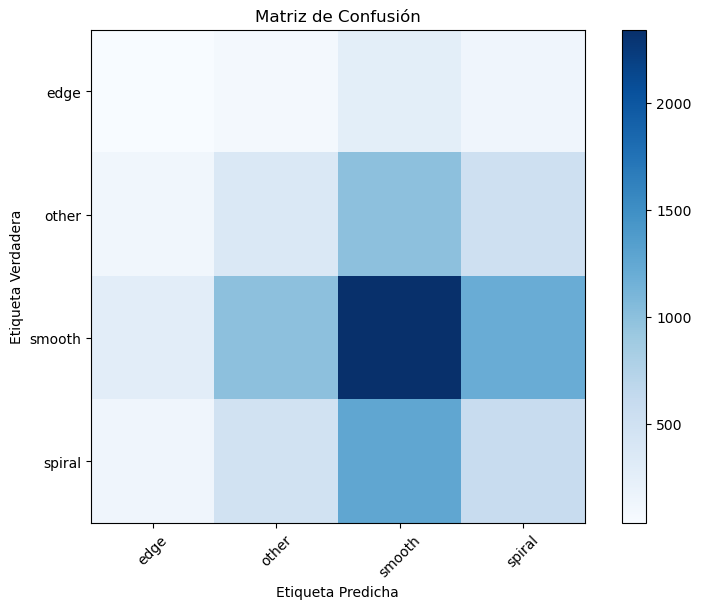

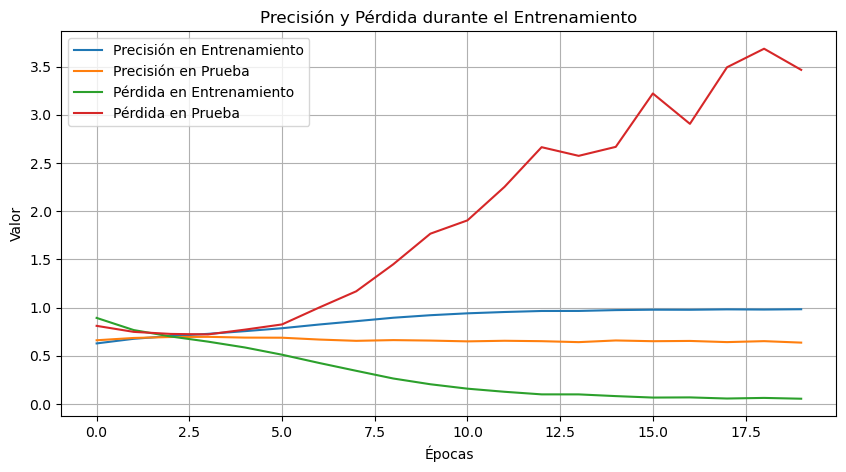

In [ ]:


# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Generar reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred))

# Generar matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Función para mostrar matriz de confusión como gráfico
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')

# Definir etiquetas de las clases
class_labels = sorted(train_generator.class_indices.keys())

# Mostrar matriz de confusión
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_labels)
plt.show()

# Generar gráfico de la precisión y pérdida en el conjunto de entrenamiento y prueba a lo largo de las épocas
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Prueba')
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Prueba')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.title('Precisión y Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()



### Banco de imágenes utilizadas durante el proyecto:

*   https://www.kaggle.com/datasets/laurenkwong/galaxydat/code

### Integrantes

*   Nicolás Campos
*   Andrés Rumillanca
*   Vicente Silva



